In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = './lfw'

In [3]:
transform = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


torch.Size([250, 250, 3])


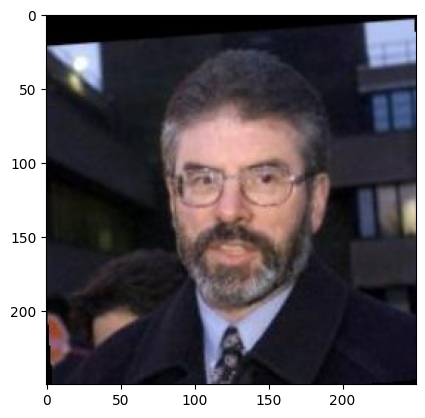

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

## Difference between Variational Auto Encoder(VAE) and Auto Encoder(AE) 

### Applications

Autoencoder (AE) is used to learn efficient embeddings of unlabeled data for a given network configuration primarly used for data compression, dimensionality reduction, and feature learning.

**Usecases:**  Image denoising, anomaly detection, and representation learning.

Variational autoencoder(VAE) addresses the issue of non-regularized latent space in autoencoder and provides the generative capability to the entire space.

**Usecases:** Image Generation by sampling points in latent space and Image synthesis.

### Architecture:

**Auto Encoder(AE):**

The autoencoder consists of two parts, an encoder, and a decoder. The encoder compresses the data from a higher-dimensional space to a lower-dimensional space called the latent space, while the decoder does the opposite i.e., convert the latent space back to higher-dimensional space. The decoder is used to ensure that latent space can capture most of the information from the dataset space, by constrain it to output what was fed as input to the decoder.

**Variational Auto Encoder (VAE):**

The Variational Autoencoder (VAE) tackles a drawback found in the regular Autoencoder (AE), which lacks a structured latent space. Unlike the AE, where the encoder produces latent vectors, the VAE's encoder instead of just producing out vectors in the latent space, the VAE's encoder gives us parameters that define a specific distribution in the latent space for each input. Now, the VAE insists that this distribution should look like a regular normal distribution, kind of like the bell curve. This rule helps organize the latent space, making it more orderly and structured. It turns out that this structured space boosts the VAE's ability to create diverse and meaningful samples when generating new images.

### Loss Function:

**Auto Encoder(AE):**
The entire encoder-decoder architecture is collectively trained on the loss function which encourages that the input is reconstructed at the output. Here we can either use MSE or Cross entropy loss functions.

**Variational Auto Encoder(VAE):**

The loss function is defined by the VAE objectives. VAE has two objectives:

- Reconstruct the input
- Latent space should be normally distributed

The training loss of VAE is defined as the sum of these the reconstruction loss and the similarity loss. The reconstruction error, just like in AE, is the mean squared loss of the input and reconstructed output. The similarity loss is the KL divergence between the latent space distribution and standard gaussian (zero mean and unit variance). The loss function is then the sum of these two losses.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    
    def __init__(self, latent_dim=64, image_channels=3, image_size=250):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_size = image_size
        
       
       # Encoder
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc_mean = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)
        self.fc_logvar = nn.Linear(64 * (image_size // 8) * (image_size // 8), latent_dim)

        # Decoder
        self.decoder_layers = nn.Sequential(
            nn.Linear(latent_dim, 64 * (image_size // 8) * (image_size // 8)),
            nn.ReLU(),
            nn.Unflatten(1, (64, image_size // 8, image_size // 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=5, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encoder(self, x):
        x = self.encoder_layers(x)
        # x = torch.flatten(x, start_dim=1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decoder(self, x):
        x = self.decoder_layers(x)
        return x

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterization(mean, logvar)
        x_recon = self.decoder(z)
        return x_recon, mean, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

## Key concepts/factors for generating new samples in latent space:

**Latent Space Representation:** In a Variational Autoencoder (VAE), the latent space serves as a compressed and continuous representation of the input data, characterized by mean and variance parameters generated by the encoder.

**Reparameterization Trick:** VAE employs the reparameterization trick to enable backpropagation through the sampling process. Instead of directly sampling from the inferred distribution, it samples from a standard normal distribution and adjusts the samples based on the inferred mean and variance.

**Generative Process:** To generate new samples in the latent space, random points are selected from the standard normal distribution and passed through the decoder. The decoder transforms these latent vectors into meaningful data points, facilitating the generation of diverse and realistic samples.

**Objective Functions:** VAE optimizes two key objectives:

1) minimizing the reconstruction error for accurate data reconstruction.
2) minimizing the Kullback-Leibler (KL) divergence between the inferred latent distribution and the standard normal distribution. This dual optimization balances accurate reconstruction with a well-structured latent space for effective generative capabilities.



In [7]:
import torch

# Instantiate the VAE model
vae_model = VAE(latent_dim=512, image_channels=3, image_size=250)

# sample batch from the dataloader
sample_batch, sample_labels = next(iter(dataloader))

# Using the first image from the batch as a sample
input_image = sample_batch[0:1] 

print("Sample image shape:", input_image.shape)

# Pass the image through the model
output_image, mean, logvar = vae_model(input_image)

# Print the shape of the output of the encoder
print("Encoder Output Shape - Mean:", mean.shape, "Log Variance:", logvar.shape)

# Generate new samples in the latent space
latent_samples = vae_model.reparameterization(mean, logvar)

# Use the decoder to create new images from the latent space samples
generated_images = vae_model.decoder(latent_samples)

# Print the shape of the output of the decoder
print("Decoder Output Shape:", generated_images.shape)

# Verify that the forward pass is working correctly
print("Original Input Image Shape:", input_image.shape)
print("Reconstructed Output Image Shape:", output_image.shape)

Sample image shape: torch.Size([1, 3, 250, 250])
Encoder Output Shape - Mean: torch.Size([1, 512]) Log Variance: torch.Size([1, 512])
Decoder Output Shape: torch.Size([1, 3, 250, 250])
Original Input Image Shape: torch.Size([1, 3, 250, 250])
Reconstructed Output Image Shape: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
* create an optimizer for training

In [41]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Total Number of trainable Parameters: {total_params}")

Total Number of trainable Parameters: 94618179


In [8]:
import torch.optim as optim

optimi = optim.Adam(vae_model.parameters(), lr=0.001)

## Loss Function

(VAE) is typically composed of two main compnents: 
- The reconstruction loss.
- The Kullback-Leibler (KL) divergence.

**Reconstruction Loss**
- Purpose: Measures fidelity of VAE-generated output to the original input. For images typically mean sqaured error (MASE) or binary cross-entropy is used to measure the dissimilarity betwween orighinal image and reconstructed distribution.
- Objective: Minimizing ensures accurate input data reconstruction, fostering meaningful latent space representations.

**Kullback-Leibler Divergence**
- Purpose: The KL divergence term measures the divergence between the learned distribution of latent variables and a chosen prior distribution, usually a standard normal distribution.
- Objective: Minimizing the KL divergence ensures that the latent space is not only informative but also adheres to a desired distribution. This regularization promotes the generation of diverse and meaningful samples in the latent space, enhancing the overall representational power of the VAE model.

**Goal of the loss function**
- The VAE's total loss comprises the sum of the reconstruction loss and the KL divergence term. By minimizing this combined loss during training, the VAE strives to achieve two key objectives: generating accurate reconstructions of input data and shaping a well-structured and informative latent space.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [9]:
vae_model.to(device)

num_epochs = 10 

for epoch in range(num_epochs):
    total_loss = 0.0
    
    for batch_data, _ in dataloader:
        # Zero the gradients
        optimi.zero_grad()

        batch_data = batch_data.to(device)
        # Forward pass
        outputs,mean,log_var = vae_model(batch_data)

        # Compute the loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        reconstruction_loss = F.mse_loss(outputs,batch_data,reduction='sum')
        loss = kl_loss + reconstruction_loss
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimi.step()
        
        total_loss += loss.item()
    
    # Print average loss at the end of each epoch
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

Epoch [1/10], Loss: 6390.741592576679
Epoch [2/10], Loss: 3584.8279160685956
Epoch [3/10], Loss: 2901.931196350665
Epoch [4/10], Loss: 2612.1670940710696
Epoch [5/10], Loss: 2418.044761487686
Epoch [6/10], Loss: 2277.303011327151
Epoch [7/10], Loss: 2165.3528222855443
Epoch [8/10], Loss: 2077.6267390293306
Epoch [9/10], Loss: 2003.4896115646484
Epoch [10/10], Loss: 1944.0032936206278


### If the loss is not decreasing as expected, we can use below methods:

**Adjust Model Complexity:**
  - Evaluate the VAE architecture, including latent space size, image size and number of channles set these values as per teh dataset.
  - Increase or decrease the layers in hidden units of encoder and decoder.

**Learning Rate:**
  - Modify the learning rate, considering its impact on convergence. 
  - Experiment with different optimizers.

**Loss Function:**
  - Ensure correct implementation of the loss function, balancing reconstruction loss and KL divergence. 
  - Experiment with MSE and Cross Entropy loss functions.

**Monitor Gradients:**
  - Examine gradients during training to prevent issues like exploding or vanishing gradients.

**Regularization Technique:**
  - Apply regularization techniques like dropout or weight regularization to mitigate overfitting.

**Hyperparameter Tuning**
  - Adjust the batch size, epochs and model complexity based on the traning error and reconstruction accuracy.



##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

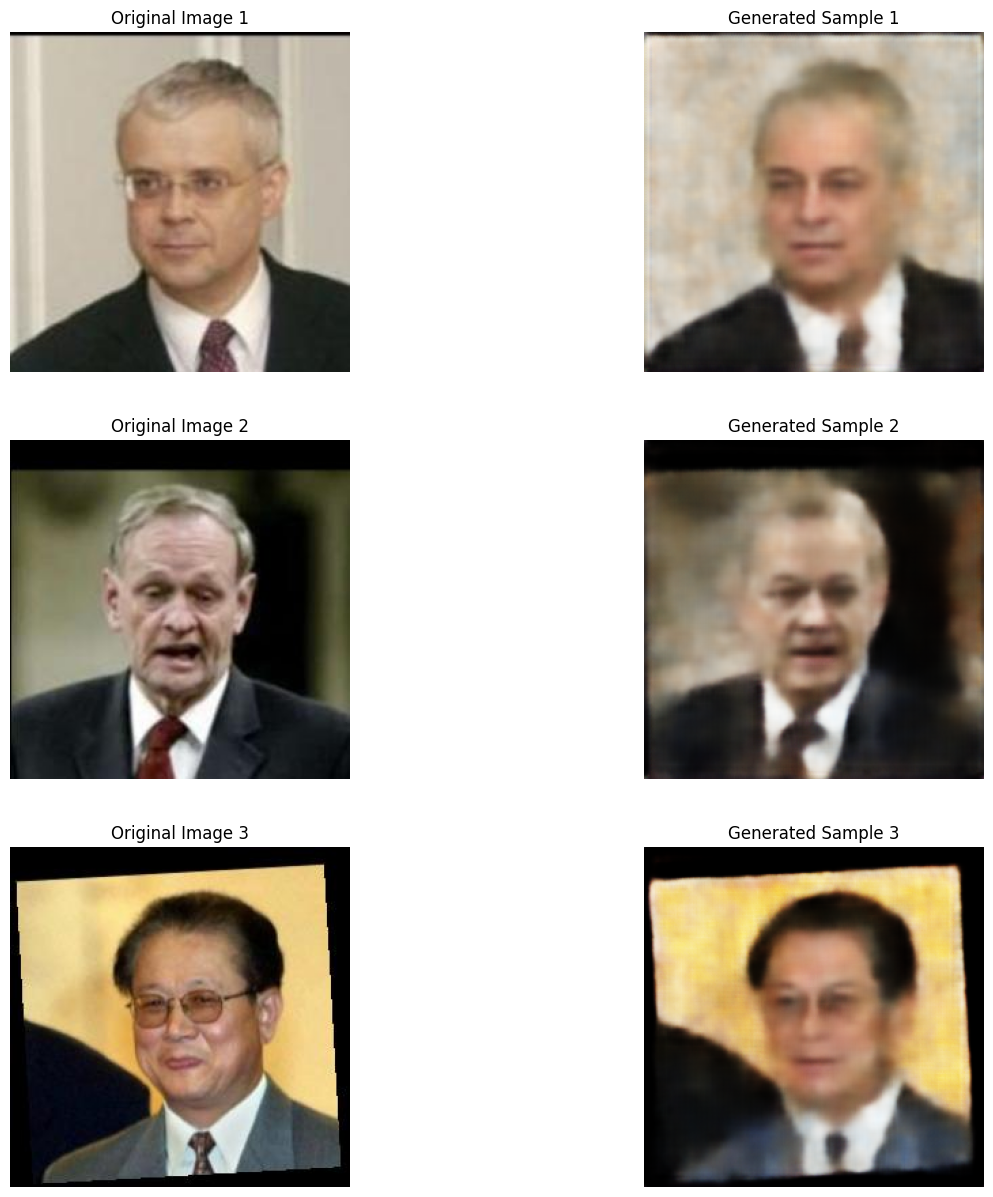

In [40]:
import matplotlib.pyplot as plt

# Number of samples to generate for each original image
num_samples = 3

# Assuming your model and dataloader are named vae_model and dataloader
vae_model.eval()

# Generate multiple random images and their corresponding samples
plt.figure(figsize=(15, 5 * num_samples))

for i in range(num_samples):
    # Choosing a random image from the dataset
    sample_index = random.randint(0, len(dataloader.dataset) - 1)
    sample_image, _ = dataloader.dataset[sample_index]

    # Adding a batch dimension to the sample image
    random_image = sample_image.unsqueeze(0).to(device)

    # Generate samples for the chosen image
    with torch.no_grad():  # Disable gradient computation
        generated_image, _, _ = vae_model(random_image)
        generated_image_np = generated_image.squeeze().cpu().detach().numpy()

    # Plot the original image
    plt.subplot(num_samples, 2, 2 * i + 1)
    original_image_np = sample_image.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(original_image_np, (1, 2, 0)))
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    # Plot the generated image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(np.transpose(generated_image_np, (1, 2, 0)))
    plt.title(f'Generated Sample {i + 1}')
    plt.axis('off')

plt.show()